In [1]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt

In [2]:
%matplotlib inline

## Create necessary classes and functions

Create class to handle "cities"

In [3]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"
    
    def as_tuple(self):
        return (self.x,self.y)

Create a fitness function

In [4]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

## Create our initial population

Route generator

In [5]:
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

Create first "population" (list of routes)

In [6]:
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

## Create the genetic algorithm

Rank individuals

In [7]:
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

Create a selection function that will be used to make the list of parent routes

In [8]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

Create mating pool

In [9]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

Create a crossover function for two parents to create one child

In [10]:
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

Create function to run crossover over full mating pool

In [11]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

Create function to mutate a single route

In [12]:
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

Create function to run mutation over entire population

In [13]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

Put all steps together to create the next generation

In [14]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

Plotting

In [15]:
def plot(route):
    xs = [x.as_tuple()[0] for x in route]
    #xs.append(route[0].as_tuple()[0]) # add first city to the end to create a loop
    ys = [x.as_tuple()[1] for x in route]
    #ys.append(route[0].as_tuple()[1]) # add first city to the end to create a loop
    plt.plot(xs, ys)
    plt.show()

Final step: create the genetic algorithm

In [16]:
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    print("Running GA for %i cities" %(len(population)))
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    
    #print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
        if i % 50 == 0:
            best_of_pop = rankRoutes(pop)[0]
            print("Best distance for generation %d: %f" %(i, 1 / best_of_pop[1]))
            plot(pop[best_of_pop[0]])
    
    best_of_pop = rankRoutes(pop)[0]
    print("Final distance: " + str(1 / best_of_pop[1]))
    bestRouteIndex = best_of_pop[0]
    bestRoute = pop[bestRouteIndex]
    
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()
    return bestRoute

## Running the genetic algorithm

Create list of cities

In [62]:
cityList = []
for i in range(0,25):
    cityList.append(City(x=int(random.random() * 200), y=int(random.random() * 200)))

Run the genetic algorithm

Initial distance: 2093.1605203836816
Best distance for generation 0: 2093.160520


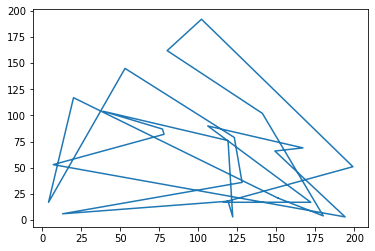

Best distance for generation 50: 999.290167


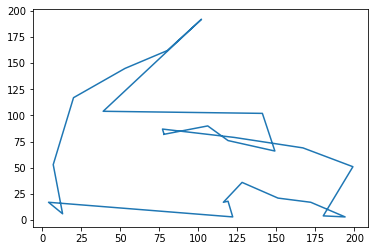

Best distance for generation 100: 891.289145


Best distance for generation 150: 824.480350


Best distance for generation 200: 809.630092


Best distance for generation 250: 809.630092


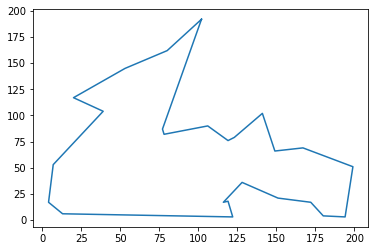

Best distance for generation 300: 807.216987


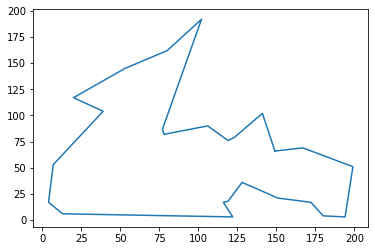

Best distance for generation 350: 807.216987


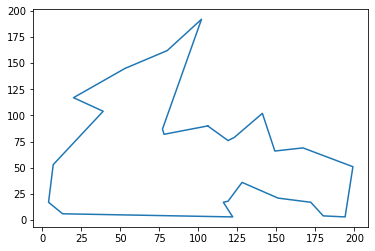

Best distance for generation 400: 807.216987


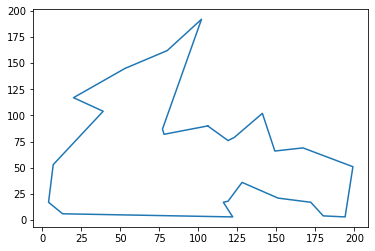

Best distance for generation 450: 807.216987


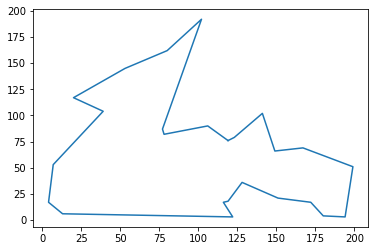

Best distance for generation 500: 807.216987


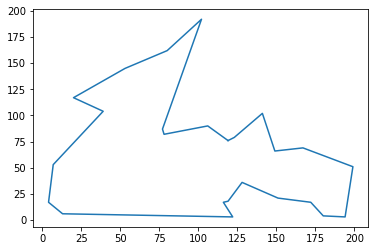

Final distance: 807.216986721729


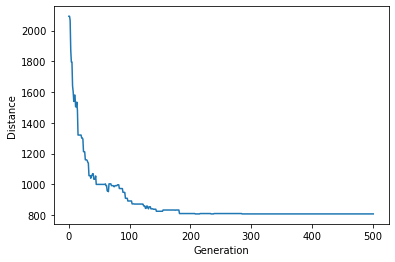

In [18]:
bestRoute = geneticAlgorithm(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=501)

In [19]:
cityList = []
for i in range(0,35):
    cityList.append(City(x=int(random.random() * 200), y=int(random.random() * 200)))

Initial distance: 2759.453918901883
Best distance for generation 0: 2617.941803


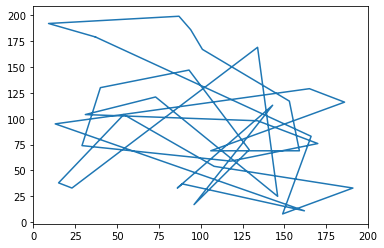

Best distance for generation 50: 1824.041288


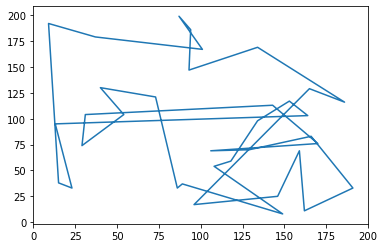

Best distance for generation 100: 1687.722870


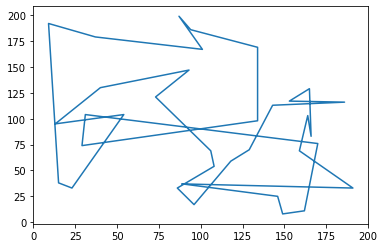

Best distance for generation 150: 1523.062688


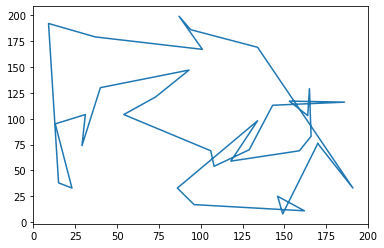

Best distance for generation 200: 1374.395560


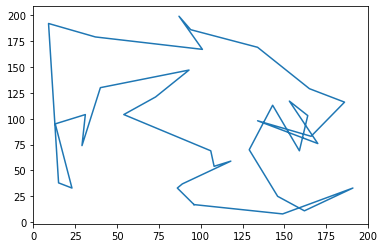

Best distance for generation 250: 1332.774286


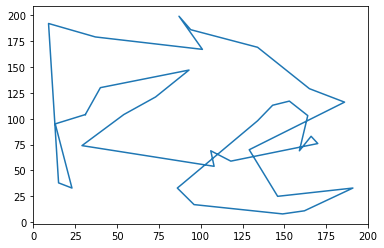

Best distance for generation 300: 1362.868398


Best distance for generation 350: 1352.923895


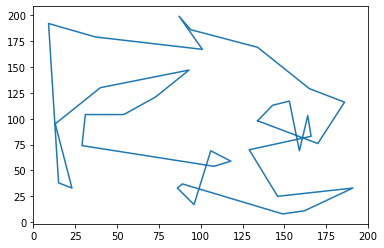

Best distance for generation 400: 1345.521827


Best distance for generation 450: 1272.586689


Best distance for generation 500: 1242.150363


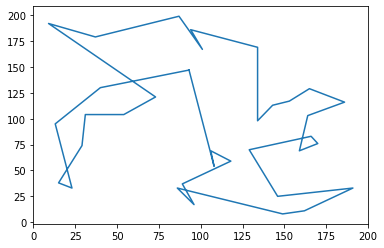

Best distance for generation 550: 1303.295492


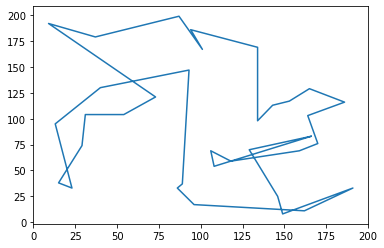

Best distance for generation 600: 1257.429130


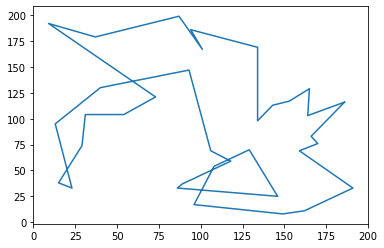

Best distance for generation 650: 1220.413526


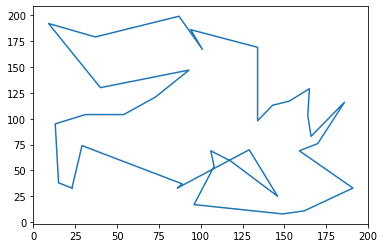

Best distance for generation 700: 1189.534147


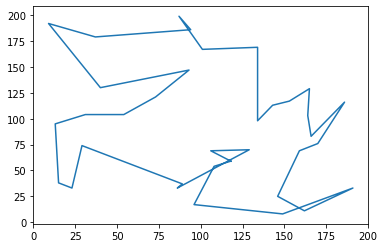

Final distance: 1189.5341469729206


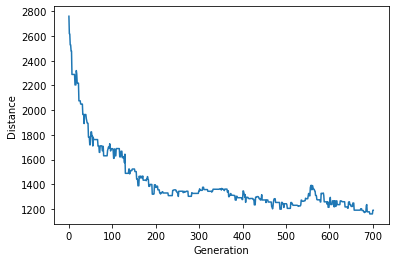

In [20]:
bestRoute = geneticAlgorithm(population=cityList, popSize=200, eliteSize=20, mutationRate=0.01, generations=701)

# Create shared tsp instances

In [24]:
import csv

In [25]:
def write_to_file(cities, filename):
    with open(filename, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerows(cities)

In [20]:
def create_instance_file(num_cities):
    cityList = []
    for i in range(0,num_cities):
        cityList.append(tuple([int(random.random() * 200), int(random.random() * 200)]))
    
    return cityList

In [31]:
write_to_file(create_instance_file(10),"tsp-instances/instance1.csv")
write_to_file(create_instance_file(20),"tsp-instances/instance2.csv")
write_to_file(create_instance_file(30),"tsp-instances/instance3.csv")
write_to_file(create_instance_file(40),"tsp-instances/instance4.csv")
write_to_file(create_instance_file(50),"tsp-instances/instance5.csv")

# Run shared tsp instances

In [17]:
def load_tsp(filename):
    fp = open(filename, 'r')
    data_list = []
    for line in fp:
        vals = line.strip().split(',')
        data_list.append(City(float(vals[0]), float(vals[1])))
    fp.close()
    return data_list

### Instance 1

In [18]:
instance1 = load_tsp("tsp-instances/instance1.csv")

Running GA for 10 cities
Best distance for generation 0: 730.102266


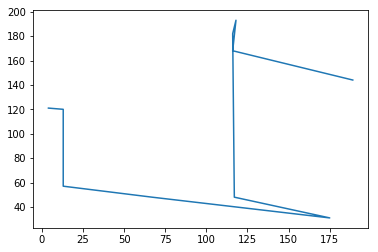

Best distance for generation 50: 577.816718


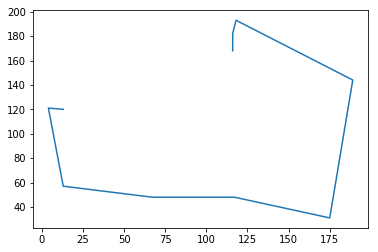

Final distance: 577.8167183002101


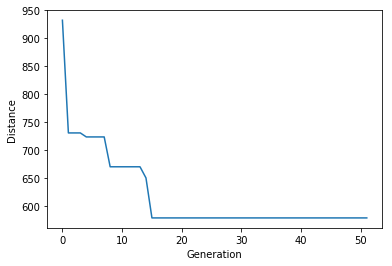

In [19]:
bestRoute1 = geneticAlgorithm(population=instance1, popSize=50, eliteSize=10, mutationRate=0.0025, generations=51)

### Instance 2

In [20]:
instance2 = load_tsp("tsp-instances/instance2.csv")

Running GA for 20 cities
Best distance for generation 0: 1586.571481


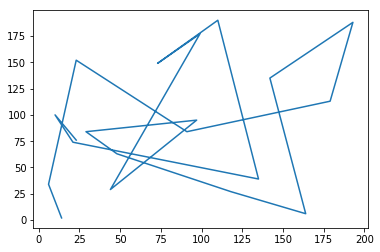

Best distance for generation 50: 1036.485786


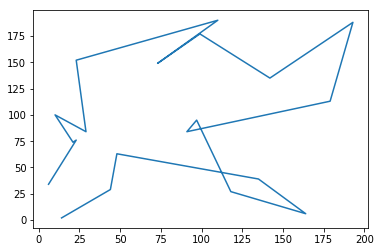

Best distance for generation 100: 926.876224


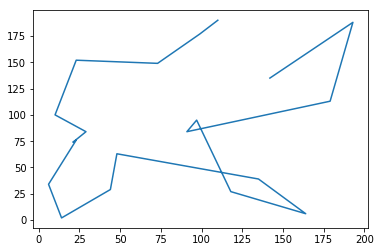

Best distance for generation 150: 872.685520


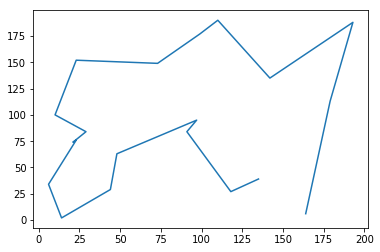

Best distance for generation 200: 864.717117


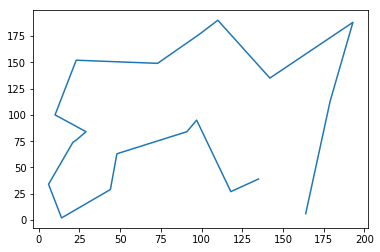

Best distance for generation 250: 850.860465


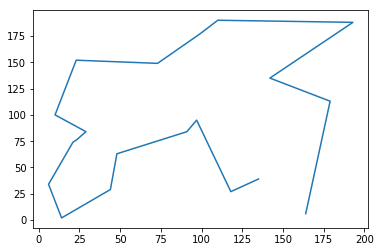

Best distance for generation 300: 850.860465


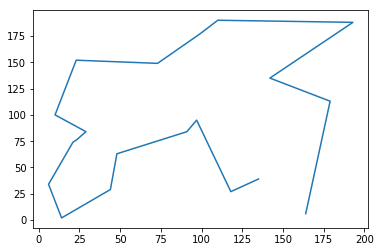

Best distance for generation 350: 850.860465


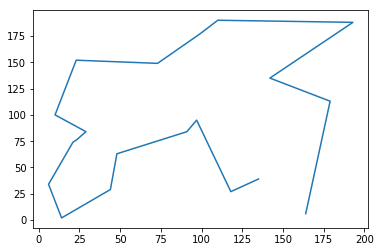

Final distance: 850.8604654416553


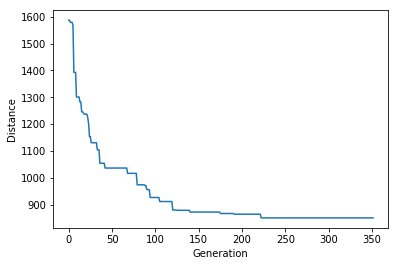

In [21]:
bestRoute2 = geneticAlgorithm(population=instance2, popSize=75, eliteSize=20, mutationRate=0.0025, generations=351)

### Instance 3

In [22]:
instance3 = load_tsp("tsp-instances/instance3.csv")

Running GA for 30 cities
Best distance for generation 0: 2569.584712


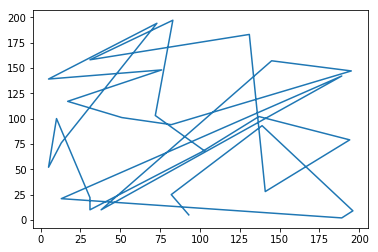

Best distance for generation 50: 1400.772902


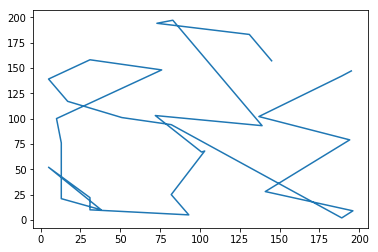

Best distance for generation 100: 1158.558616


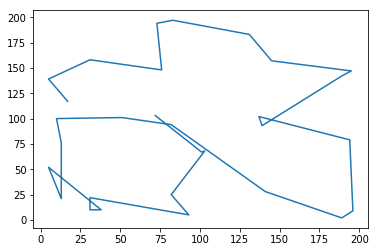

Best distance for generation 150: 1031.994829


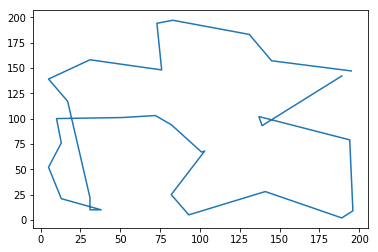

Best distance for generation 200: 1018.555448


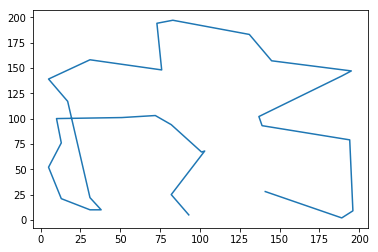

Best distance for generation 250: 1018.555448


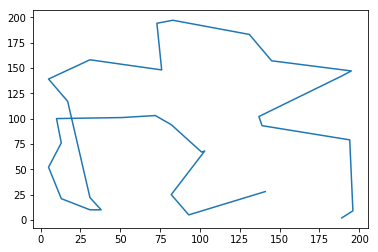

Best distance for generation 300: 1018.555448


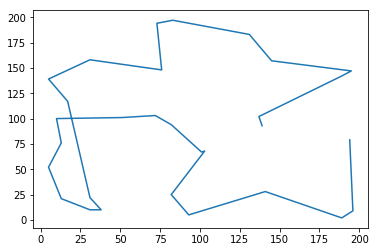

Best distance for generation 350: 1017.205628


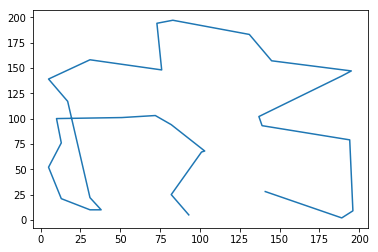

Best distance for generation 400: 1017.205628


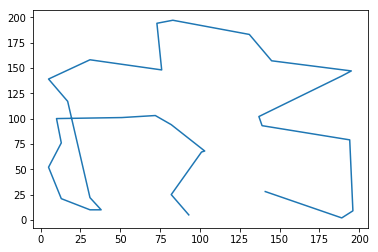

Best distance for generation 450: 1017.205628


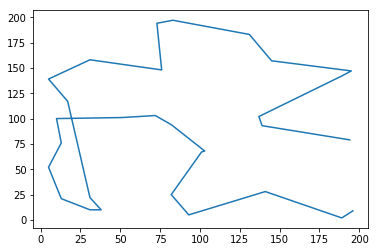

Best distance for generation 500: 1017.205628


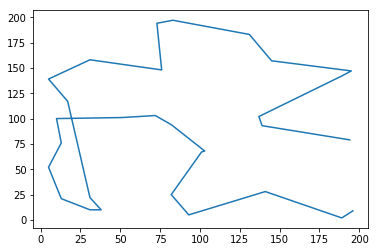

Best distance for generation 550: 1017.205628


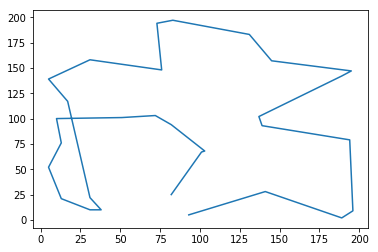

Best distance for generation 600: 1017.205628


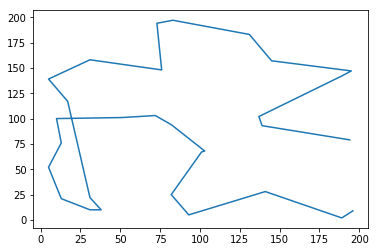

Best distance for generation 650: 1000.629133


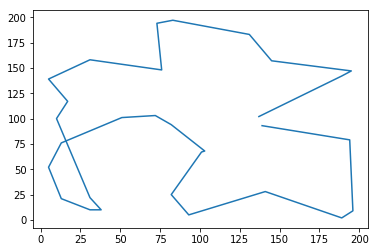

Best distance for generation 700: 997.383580


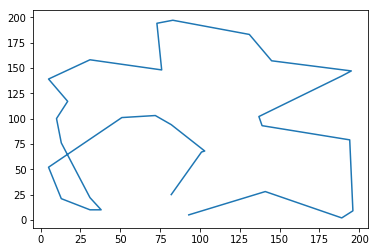

Best distance for generation 750: 997.383580


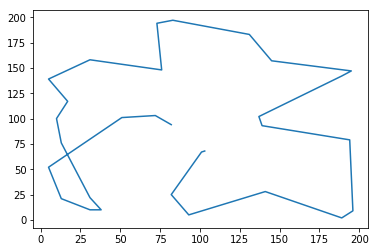

Best distance for generation 800: 997.383580


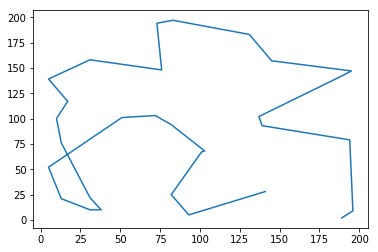

Best distance for generation 850: 997.383580


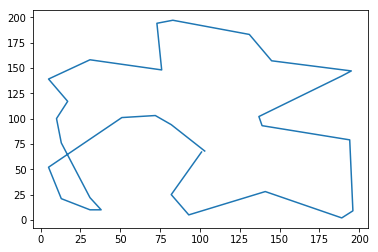

Final distance: 997.3835796024078


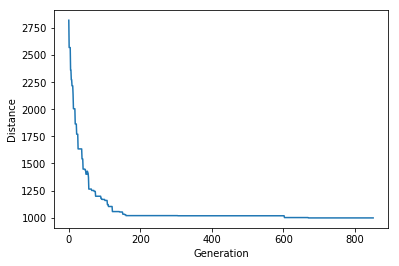

In [32]:
bestRoute3 = geneticAlgorithm(population=instance3, popSize=150, eliteSize=40, mutationRate=0.0025, generations=851)

### Instance 4

In [25]:
instance4 = load_tsp("tsp-instances/instance4.csv")

Running GA for 40 cities
Best distance for generation 0: 3422.497327


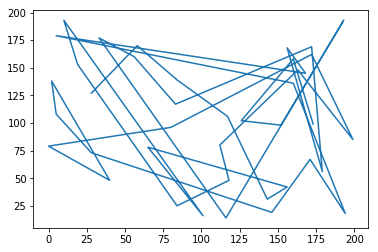

Best distance for generation 50: 1807.265166


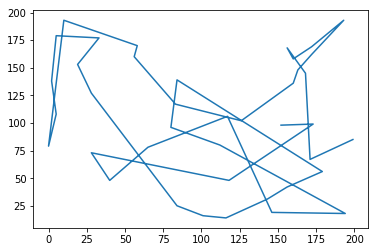

Best distance for generation 100: 1437.186870


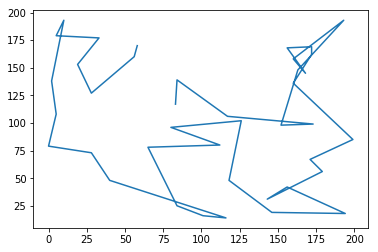

Best distance for generation 150: 1302.838711


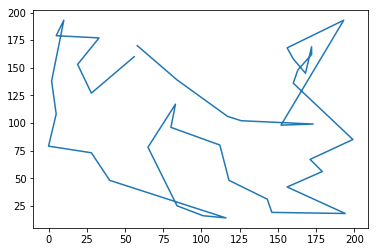

Best distance for generation 200: 1248.493893


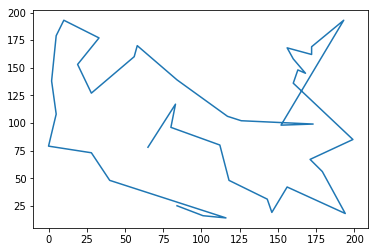

Best distance for generation 250: 1211.051762


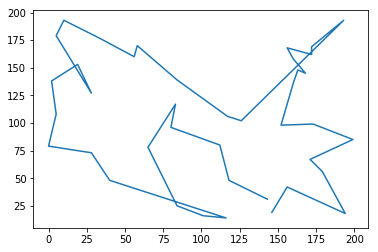

Best distance for generation 300: 1140.544533


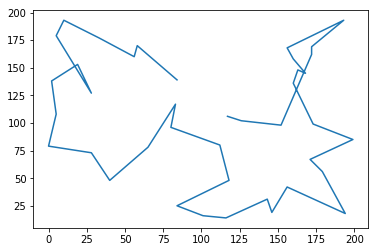

Best distance for generation 350: 1102.837748


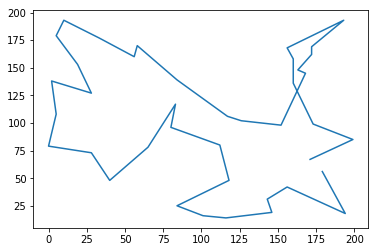

Best distance for generation 400: 1082.249141


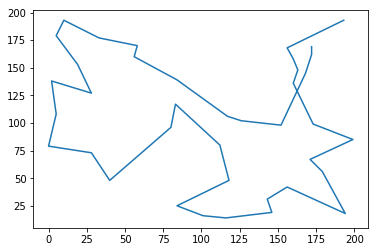

Best distance for generation 450: 1090.348187


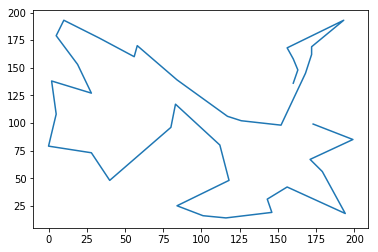

Best distance for generation 500: 1090.348187


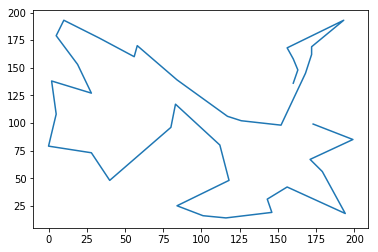

Best distance for generation 550: 1082.249141


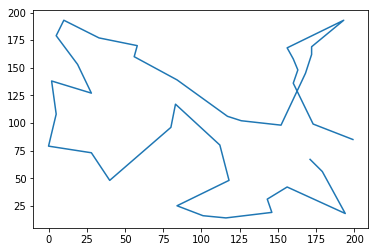

Best distance for generation 600: 1060.540336


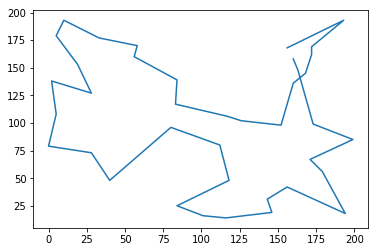

Best distance for generation 650: 1060.540336


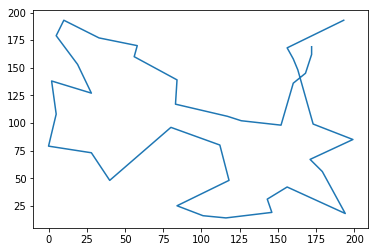

Best distance for generation 700: 1060.540336


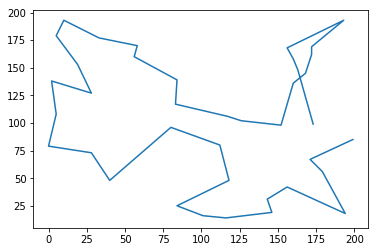

Best distance for generation 750: 1060.540336


Best distance for generation 800: 1060.540336


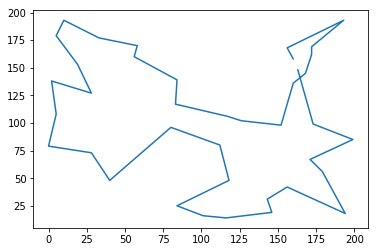

Best distance for generation 850: 1055.381512


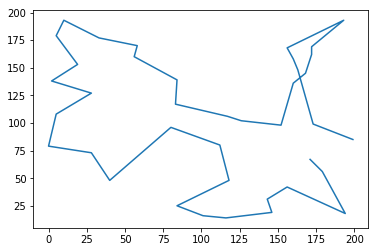

Best distance for generation 900: 1055.381512


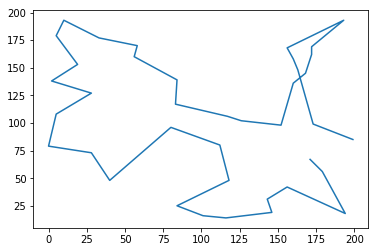

Best distance for generation 950: 1055.381512


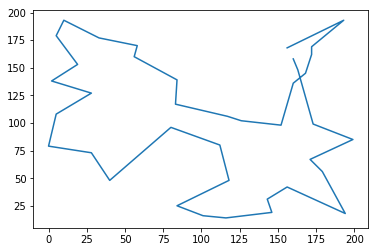

Best distance for generation 1000: 1055.381512


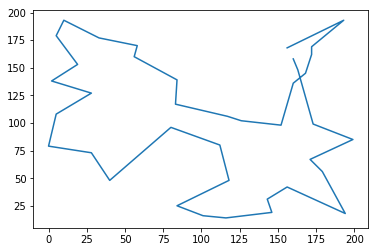

Best distance for generation 1050: 1055.381512


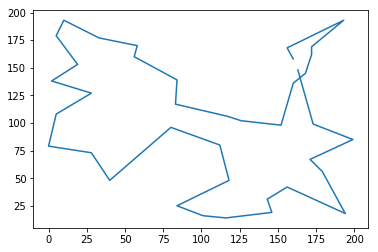

Best distance for generation 1100: 1055.381512


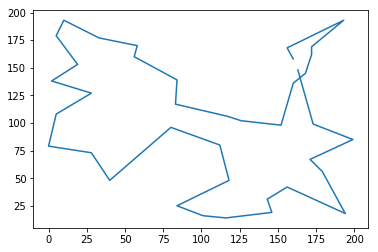

Best distance for generation 1150: 1055.381512


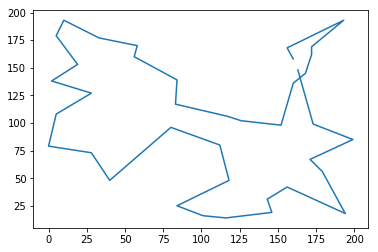

Best distance for generation 1200: 1055.381512


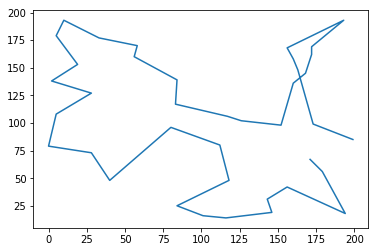

Best distance for generation 1250: 1055.381512


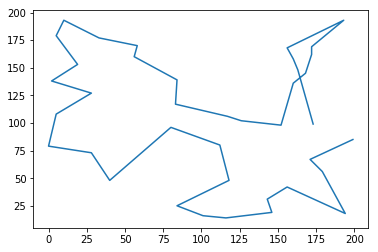

Best distance for generation 1300: 1055.381512


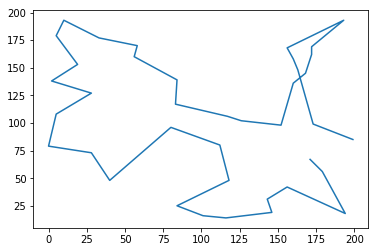

Best distance for generation 1350: 1055.381512


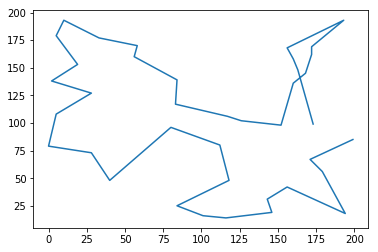

Best distance for generation 1400: 1055.381512


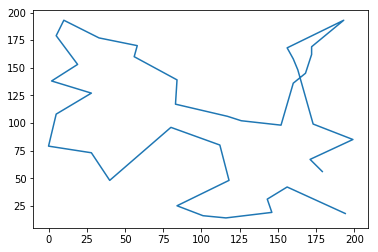

Best distance for generation 1450: 1055.381512


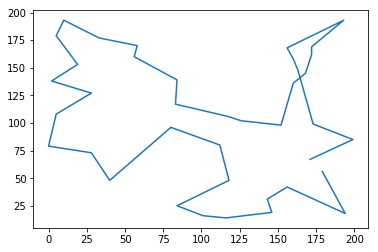

Best distance for generation 1500: 1055.381512


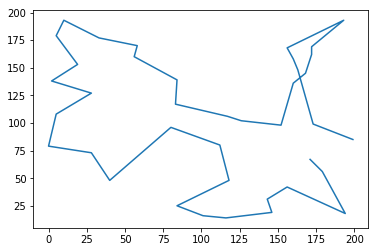

Final distance: 1055.381511841887


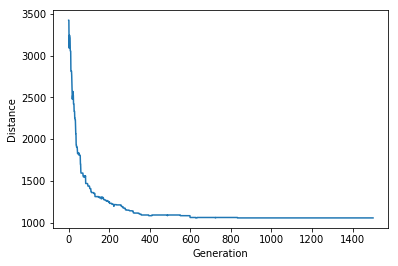

In [26]:
bestRoute4 = geneticAlgorithm(population=instance4, popSize=250, eliteSize=55, mutationRate=0.0025, generations=1501)

### Instance 5

In [33]:
instance5 = load_tsp("tsp-instances/instance5.csv")

Running GA for 50 cities
Best distance for generation 0: 4133.696795


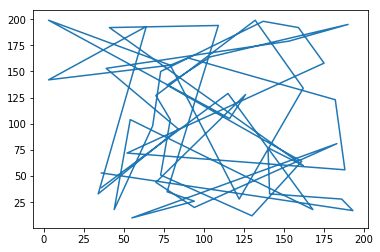

Best distance for generation 50: 2822.662002


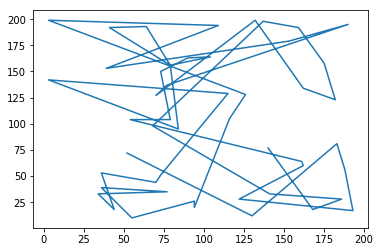

Best distance for generation 100: 2086.186442


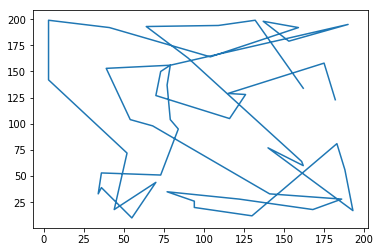

Best distance for generation 150: 1881.359157


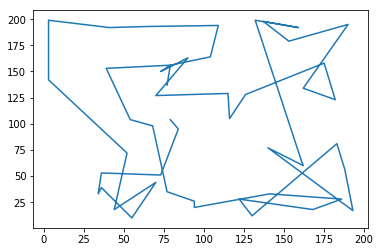

Best distance for generation 200: 1729.071031


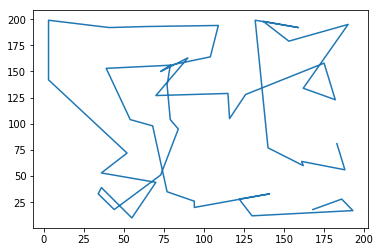

Best distance for generation 250: 1578.561184


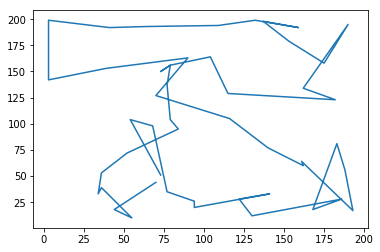

Best distance for generation 300: 1450.584368


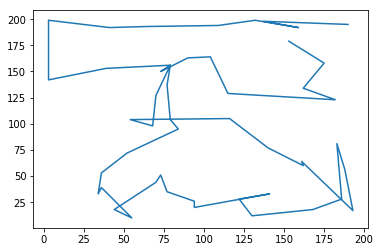

Best distance for generation 350: 1341.624088


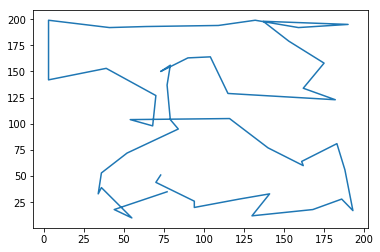

Best distance for generation 400: 1283.562228


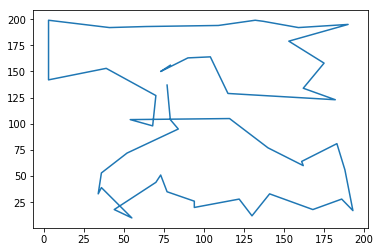

Best distance for generation 450: 1269.193992


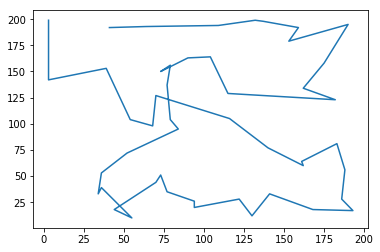

Best distance for generation 500: 1244.000213


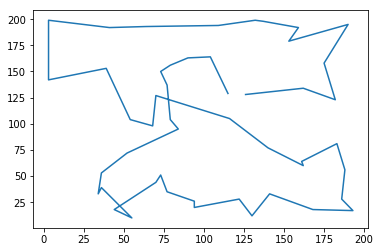

Best distance for generation 550: 1236.819956


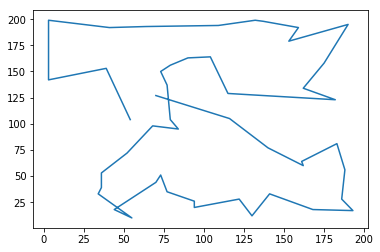

Best distance for generation 600: 1216.785819


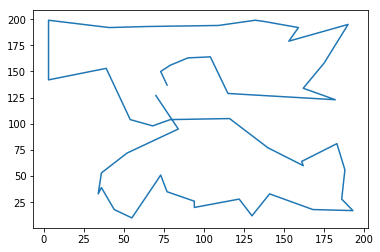

Best distance for generation 650: 1227.508856


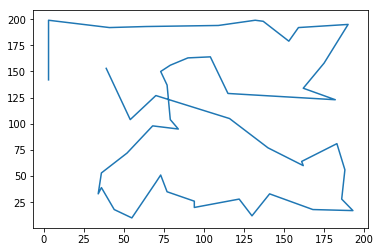

Best distance for generation 700: 1216.181108


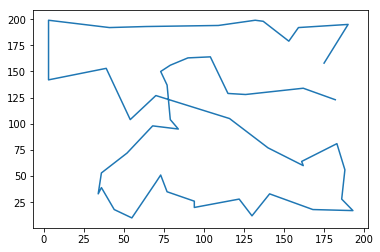

Best distance for generation 750: 1214.972016


Best distance for generation 800: 1192.934820


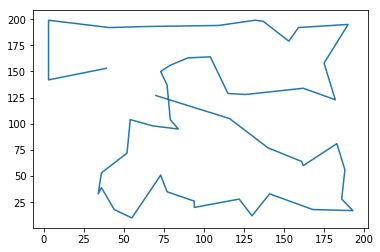

Best distance for generation 850: 1192.934820


Best distance for generation 900: 1188.439944


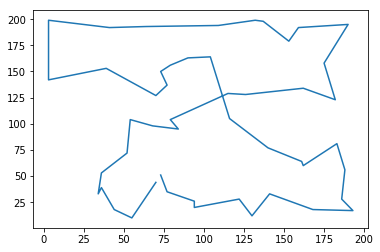

Best distance for generation 950: 1188.439944


Best distance for generation 1000: 1188.439944


Best distance for generation 1050: 1177.895744


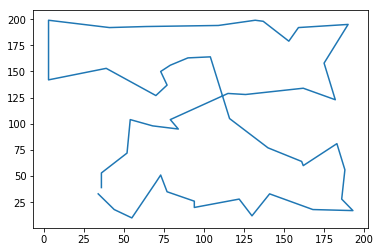

Best distance for generation 1100: 1188.439944


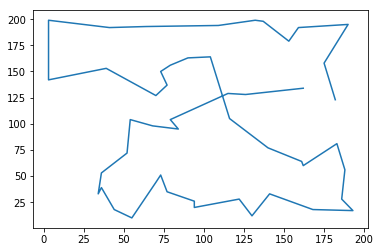

Best distance for generation 1150: 1186.872742


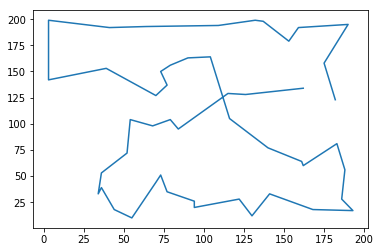

Best distance for generation 1200: 1186.872742


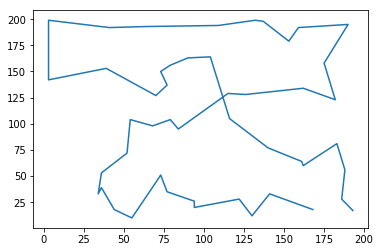

Best distance for generation 1250: 1176.328542


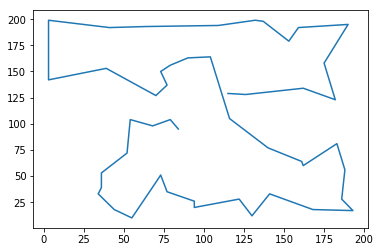

Best distance for generation 1300: 1176.328542


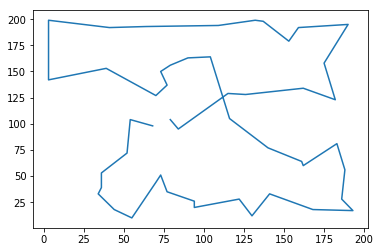

Best distance for generation 1350: 1175.177503


Best distance for generation 1400: 1175.177503


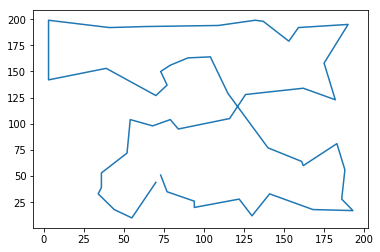

Best distance for generation 1450: 1175.177503


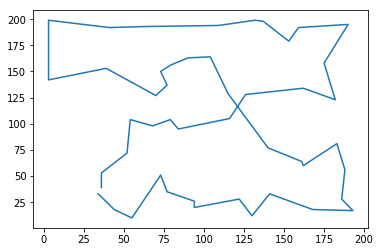

Best distance for generation 1500: 1175.177503


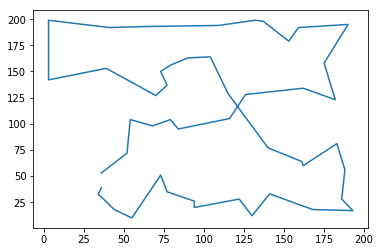

Final distance: 1175.1775029122252


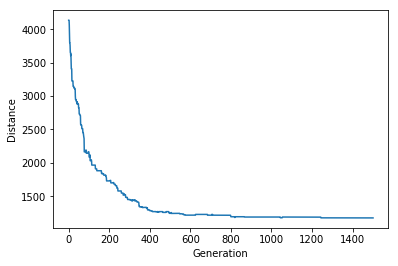

In [39]:
bestRoute5 = geneticAlgorithm(population=instance5, popSize=250, eliteSize=30, mutationRate=0.0025, generations=1501)

Initial distance: 1308.670013006338
Best distance for generation 0: 1308.670013


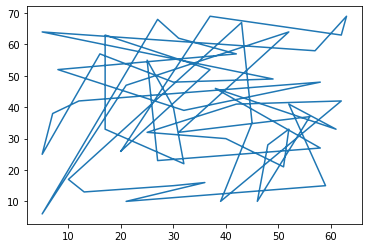

Best distance for generation 50: 879.694512


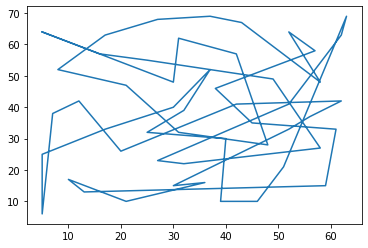

Best distance for generation 100: 716.241027


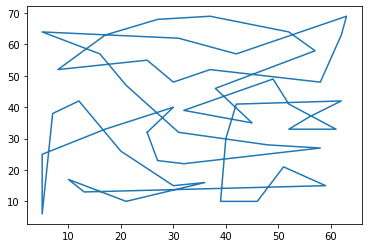

Best distance for generation 150: 613.783137


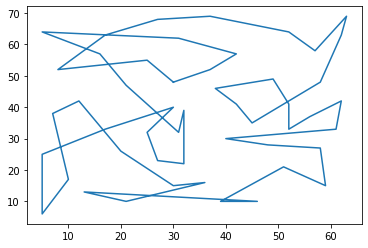

Best distance for generation 200: 571.976215


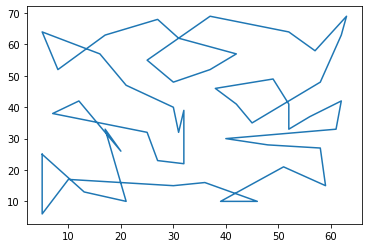

Best distance for generation 250: 534.373066


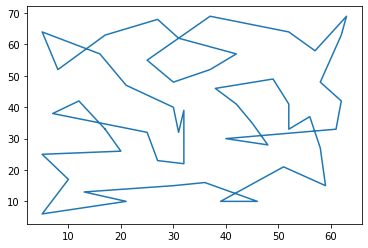

Best distance for generation 300: 509.158934


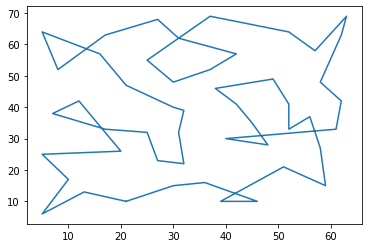

Best distance for generation 350: 498.639724


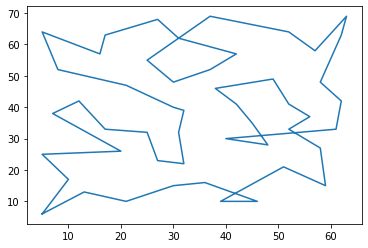

Best distance for generation 400: 497.493243


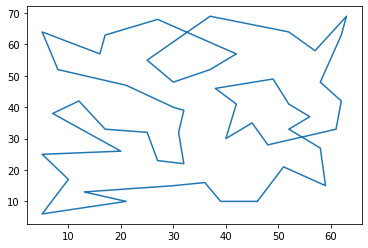

Best distance for generation 450: 490.117130


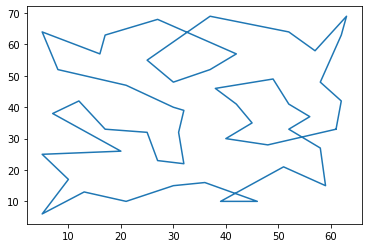

Best distance for generation 500: 487.647770


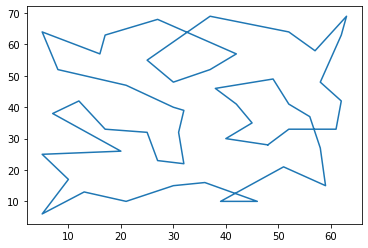

Best distance for generation 550: 486.882457


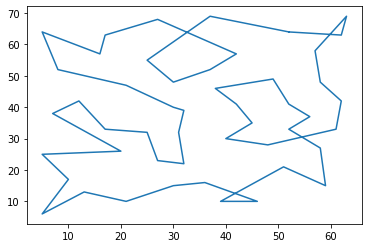

Best distance for generation 600: 483.063091


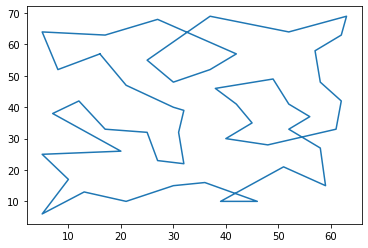

Best distance for generation 650: 460.547939


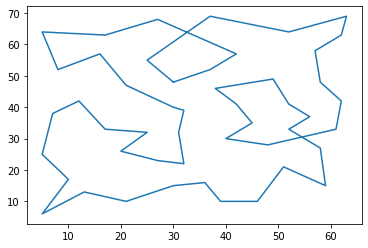

Best distance for generation 700: 460.447885


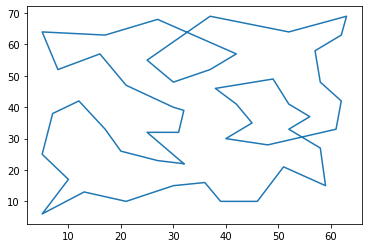

Best distance for generation 750: 460.547939


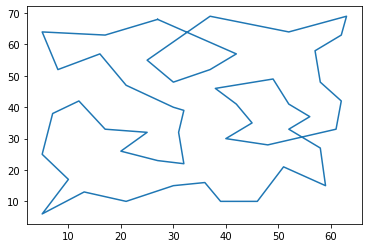

Best distance for generation 800: 460.547939


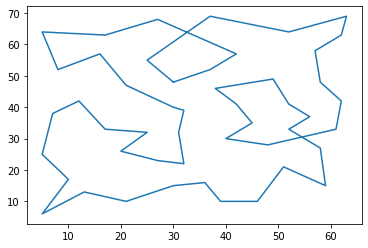

Best distance for generation 850: 460.547939


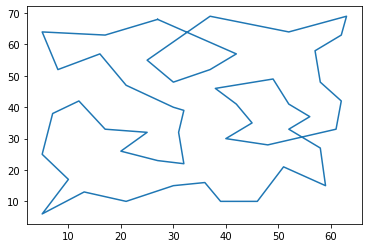

Best distance for generation 900: 458.078578


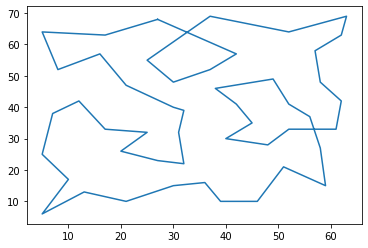

Best distance for generation 950: 458.078578


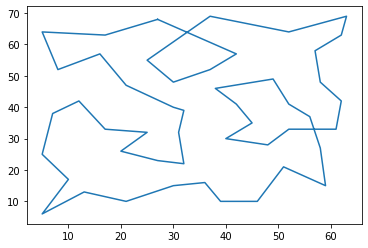

Best distance for generation 1000: 458.078578


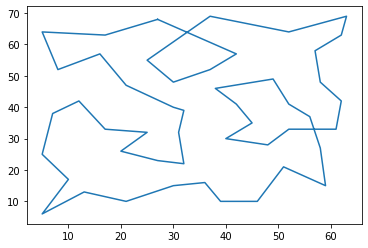

Best distance for generation 1050: 458.001198


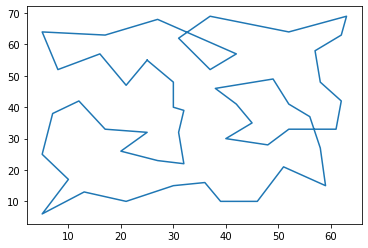

Best distance for generation 1100: 453.716313


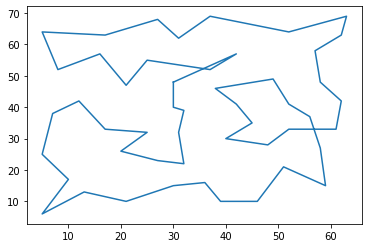

Best distance for generation 1150: 451.492491


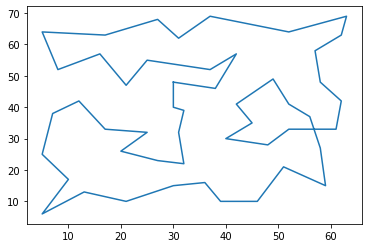

Best distance for generation 1200: 450.640594


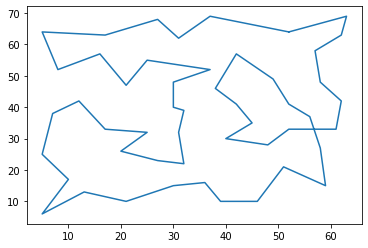

Best distance for generation 1250: 447.621584


Best distance for generation 1300: 447.621584


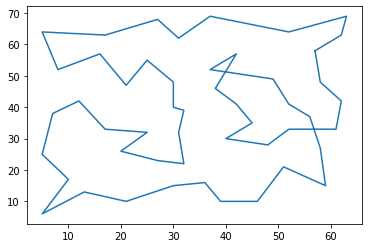

Best distance for generation 1350: 447.621584


Best distance for generation 1400: 446.644876


Best distance for generation 1450: 437.675978


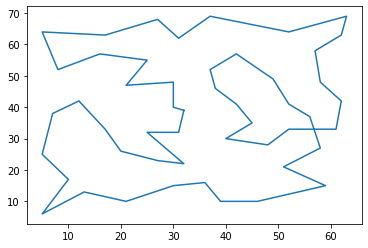

Best distance for generation 1500: 437.675978


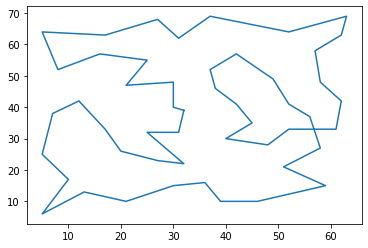

Final distance: 437.6759775117674


In [32]:
bestRoute1 = geneticAlgorithm(population=instance1, popSize=250, eliteSize=30, mutationRate=0.0025, generations=1501)